# Simulating an All-Pass Filter
> A simple comparison between an analytical evaluation of an all pass filter and using SAX.

In [1]:
import jax
import jax.example_libraries.optimizers as opt
import jax.numpy as jnp
import matplotlib.pyplot as plt
import sax
import tqdm

## Schematic
```

           in0---out0
        in1          out1
           \        /
            ========
           /        \
 in0 <- in0          out0 -> out0
```

## Simulation & Design Parameters

In [2]:
loss = 0.1  # [dB/μm] (alpha) waveguide loss
neff = 2.34  # Effective index of the waveguides
ng = 3.4  # Group index of the waveguides
wl0 = 1.55  # [μm] the wavelength at which neff and ng are defined
ring_length = 10.0  # [μm] Length of the ring
coupling = 0.5  # [] coupling of the coupler
wl = jnp.linspace(1.5, 1.6, 1000)  # [μm] Wavelengths to sweep over

## Frequency Domain Analytically

As a comparison, we first calculate the frequency domain response for the all-pass filter analytically:
\begin{align*}
o = \frac{t-10^{-\alpha L/20}\exp(2\pi j n_{\rm eff}(\lambda) L / \lambda)}{1-t10^{-\alpha L/20}\exp(2\pi j n_{\rm eff}(\lambda) L / \lambda)}s
\end{align*}

In [3]:
def all_pass_analytical():
    """ Analytic Frequency Domain Response of an all pass filter """
    detected = jnp.zeros_like(wl)
    transmission = 1 - coupling
    neff_wl = neff + (wl0 - wl) * (ng - neff) / wl0  # we expect a linear behavior with respect to wavelength
    out = jnp.sqrt(transmission) - 10 ** (-loss * ring_length / 20.0) * jnp.exp(2j * jnp.pi * neff_wl * ring_length / wl)
    out /= 1 - jnp.sqrt(transmission) * 10 ** (-loss * ring_length / 20.0) * jnp.exp(2j * jnp.pi * neff_wl * ring_length / wl)
    detected = abs(out) ** 2
    return detected

CPU times: user 351 ms, sys: 302 µs, total: 351 ms
Wall time: 349 ms
CPU times: user 65.8 ms, sys: 0 ns, total: 65.8 ms
Wall time: 65 ms
CPU times: user 652 µs, sys: 0 ns, total: 652 µs
Wall time: 468 µs


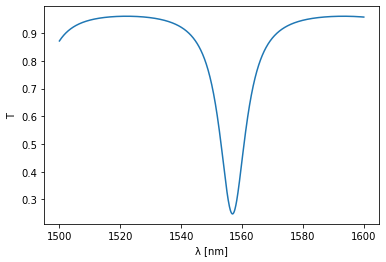

In [4]:
%time detected = all_pass_analytical() # non-jitted evaluation time
all_pass_analytical_jitted = jax.jit(all_pass_analytical)
%time detected = all_pass_analytical_jitted() # time to jit
%time detected = all_pass_analytical_jitted() # evaluation time after jitting

plt.plot(wl * 1e3, detected)
plt.xlabel("λ [nm]")
plt.ylabel("T")
plt.show()

## Scatter Dictionaries

In [5]:
all_pass_sax = sax.circuit(
    instances={
        "dc": sax.partial(sax.models.coupler, coupling=coupling),
        "top": sax.partial(sax.models.straight, length=ring_length, loss=loss, neff=neff, ng=ng, wl0=wl0, wl=wl),
    },
    connections={
        "dc,out1": "top,in0",
        "top,out0": "dc,in1",
    },
    ports={
        "in0": "dc,in0",
        "out0": "dc,out0",
    },
)

/opt/conda/lib/python3.9/site-packages/jax/_src/numpy/lax_numpy.py:3658: UserWarning: Explicitly requested dtype <class 'complex'> requested in asarray is not available, and will be truncated to dtype complex64. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "asarray")


CPU times: user 2.32 s, sys: 12 ms, total: 2.33 s
Wall time: 2.33 s
CPU times: user 767 µs, sys: 0 ns, total: 767 µs
Wall time: 565 µs
CPU times: user 311 µs, sys: 0 ns, total: 311 µs
Wall time: 200 µs


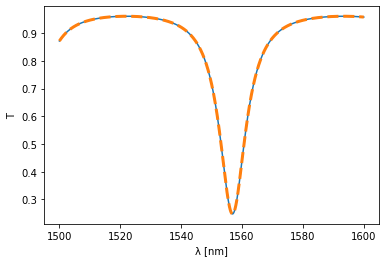

In [6]:
%time detected_sax = all_pass_sax() # non-jitted evaluation time
all_pass_sax_jitted = jax.jit(all_pass_analytical)
%time detected_sax = all_pass_sax_jitted() # time to jit
%time detected_sax = all_pass_sax_jitted() # time after jitting

plt.plot(wl * 1e3, detected, label="analytical")
plt.plot(wl * 1e3, detected_sax, label="sax", ls="--", lw=3)
plt.xlabel("λ [nm]")
plt.ylabel("T")
plt.show()